In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define tickers for each sector
sectors = {
    "Tech": ["INFY.NS", "TCS.NS", "HCLTECH.NS", "WIPRO.NS", "TECHM.NS"],
    "Power": ["NTPC.NS", "POWERGRID.NS", "TATAPOWER.NS", "ADANIPOWER.NS", "NHPC.NS"],
    "Auto": ["M&M.NS", "MARUTI.NS", "BAJAJ-AUTO.NS", "HEROMOTOCO.NS", "TATAMOTORS.NS"],
    "Bank": ["HDFCBANK.NS", "SBIN.NS", "ICICIBANK.NS", "AXISBANK.NS", "KOTAKBANK.NS"],
    "Real Estate": ["DLF.NS", "GODREJPROP.NS", "OBEROIRLTY.NS", "PRESTIGE.NS", "BRIGADE.NS"]
}

# Combine all tickers
all_tickers = [ticker for sector_tickers in sectors.values() for ticker in sector_tickers]

data = yf.download(all_tickers, start="2021-01-01", end="2021-12-31")["Close"]

# Reset index to make 'Date' a column
data = data.reset_index()

# Convert from wide format to long format
melted_data = data.melt(id_vars=["Date"], var_name="Ticker", value_name="Close")

# Map each ticker to its sector
ticker_to_sector = {ticker: sector for sector, tickers in sectors.items() for ticker in tickers}
melted_data["Sector"] = melted_data["Ticker"].map(ticker_to_sector)

# Create a DataFrame structured by sectors
sector_dataframes = {}

for sector in sectors.keys():
    df_sector = melted_data[melted_data["Sector"] == sector].copy()
    df_sector = df_sector.drop(columns=["Sector"])
    df_sector = df_sector.set_index("Date").sort_index()
    sector_dataframes[sector] = df_sector

# Concatenate all sector-wise data with MultiIndex columns
final_df = pd.concat(sector_dataframes.values(), axis=1, keys=sector_dataframes.keys())

# Display the final structured MultiIndex DataFrame
print(final_df.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  25 of 25 completed


                  Tech                       Power                      Auto  \
                Ticker        Close         Ticker      Close         Ticker   
Date                                                                           
2021-01-01  HCLTECH.NS   815.363281  ADANIPOWER.NS  50.150002  BAJAJ-AUTO.NS   
2021-01-01      TCS.NS  2724.912842        NTPC.NS  80.096519         M&M.NS   
2021-01-01    TECHM.NS   868.555481   POWERGRID.NS  84.792725      MARUTI.NS   
2021-01-01     INFY.NS  1148.968384        NHPC.NS  18.831123  HEROMOTOCO.NS   
2021-01-01    WIPRO.NS   183.983368   TATAPOWER.NS  74.745972  TATAMOTORS.NS   

                                 Bank                 Real Estate               
                  Close        Ticker        Close         Ticker        Close  
Date                                                                            
2021-01-01  3121.441406   AXISBANK.NS   621.093872     BRIGADE.NS   246.471161  
2021-01-01   697.082214  ICICIBANK.

C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


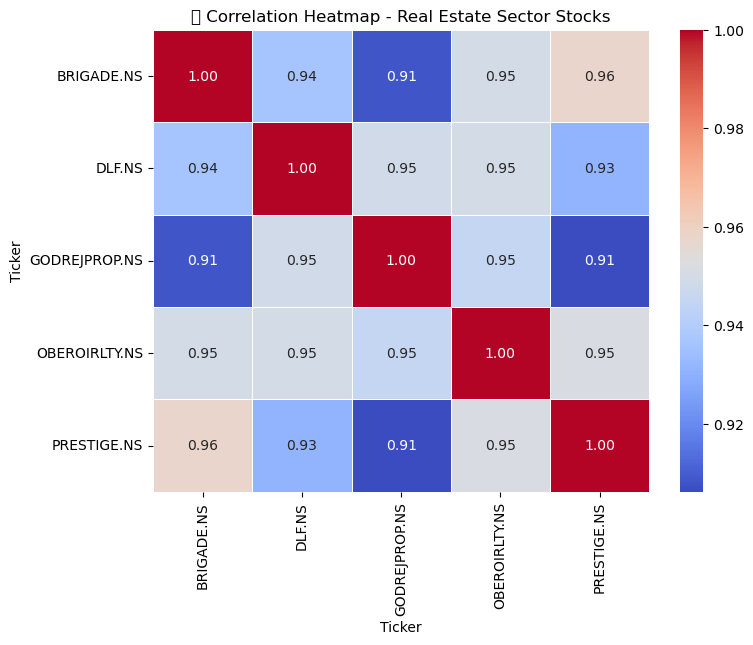

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the 'Bank' sector from the MultiIndex DataFrame
real_data = final_df["Real Estate"]

# Pivot the data: Rows → Date, Columns → Ticker, Values → Close Price
real_pivot = real_data.pivot_table(index="Date", columns="Ticker", values="Close")

# Compute the correlation matrix
correlation_matrix = real_pivot.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("📈 Correlation Heatmap - Real Estate Sector Stocks")
plt.show()


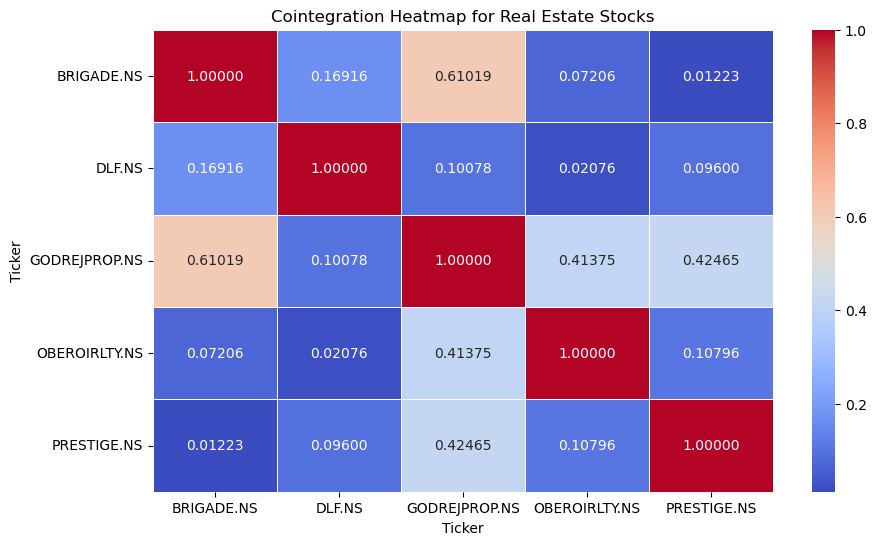

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

# Extract bank sector data from multi-index DataFrame
real_data = final_df["Real Estate"]

# Convert to pivot table: Date as index, Ticker as columns, Close as values
real_pivot = real_data.pivot_table(index="Date", columns="Ticker", values="Close")

# Drop NaN values
real_pivot.dropna(inplace=True)

# Get list of tickers
tickers = real_pivot.columns

# Create a matrix to store cointegration p-values
coint_matrix = pd.DataFrame(np.ones((len(tickers), len(tickers))), index=tickers, columns=tickers)

# Compute p-values for each pair
for i in range(len(tickers)):
    for j in range(i + 1, len(tickers)):  # Avoid duplicate pairs
        stock1, stock2 = tickers[i], tickers[j]
        
        # Compute cointegration test p-value
        _, p_value, _ = coint(real_pivot[stock1], real_pivot[stock2])
        
        # Store p-value in matrix (symmetrical)
        coint_matrix.loc[stock1, stock2] = p_value
        coint_matrix.loc[stock2, stock1] = p_value

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(coint_matrix, annot=True, fmt=".5f", cmap="coolwarm", linewidths=0.5)
plt.title("Cointegration Heatmap for Real Estate Stocks")
plt.show()


In [4]:
# List of tickers in the bank sector
tickers = real_pivot.columns

# Store cointegrated pairs
cointegrated_pairs = []

# Iterate through all stock pairs
for i in range(len(tickers)):
    for j in range(i + 1, len(tickers)):
        stock1 = tickers[i]
        stock2 = tickers[j]
        
        # Perform Engle-Granger Cointegration Test
        score, p_value, _ = coint(real_pivot[stock1], real_pivot[stock2])
        
        # Consider pairs with p-value ≤ 0.05
        if p_value <= 0.05:
            cointegrated_pairs.append((stock1, stock2, p_value))

# Display Cointegrated Pairs
print("Cointegrated Stock Pairs (p-value ≤ 0.05):")
for pair in cointegrated_pairs:
    print(f"{pair[0]} & {pair[1]} - P-value: {pair[2]:.5f}")


Cointegrated Stock Pairs (p-value ≤ 0.05):
BRIGADE.NS & PRESTIGE.NS - P-value: 0.01223
DLF.NS & OBEROIRLTY.NS - P-value: 0.02076


In [49]:
import statsmodels.api as sm

# Extract SBI & Kotak Close Prices from the Bank sector
dlf_close = real_pivot["DLF.NS"]
oberoi_close = real_pivot["OBEROIRLTY.NS"]

# Identify which stock is the independent variable
if dlf_close.mean() > oberoi_close.mean():
    X = dlf_close  # Predictor
    Y = oberoi_close  # Dependent
else:
    X = oberoi_close
    Y = dlf_close

# Add a constant for intercept in OLS
X = sm.add_constant(X)

# Build OLS Model
model = sm.OLS(Y, X).fit()

# Print model summary
print(model.summary())

# Get slope (beta) & intercept
intercept, beta = model.params
print(f"Intercept: {intercept}, Beta: {beta}")


                            OLS Regression Results                            
Dep. Variable:                 DLF.NS   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     2256.
Date:                Wed, 26 Feb 2025   Prob (F-statistic):          1.36e-125
Time:                        16:13:16   Log-Likelihood:                -1058.1
No. Observations:                 247   AIC:                             2120.
Df Residuals:                     245   BIC:                             2127.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            62.2057      5.519     11.271

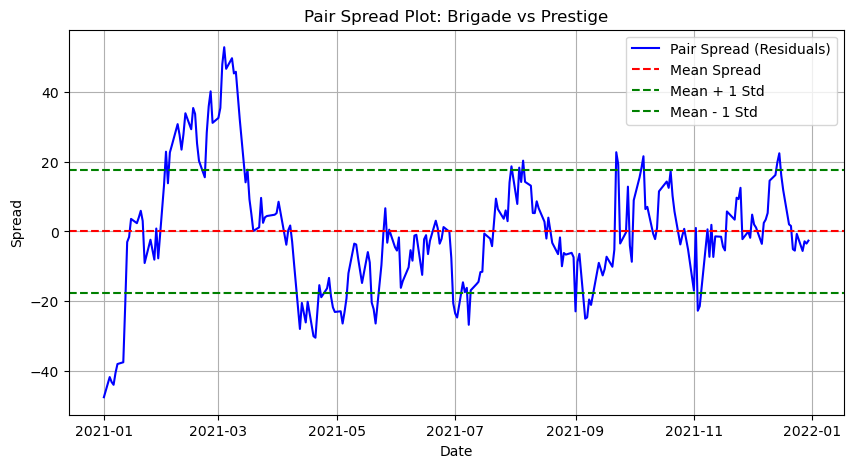

In [54]:
import matplotlib.pyplot as plt

# Extract stock prices
dlf_close = real_pivot["DLF.NS"]
oberoi_close = real_pivot["OBEROIRLTY.NS"]

# Run OLS Regression
X = sm.add_constant(oberoi_close)  
Y = dlf_close 
model = sm.OLS(Y, X).fit()

# Compute Residuals (Spread)
spread = Y - model.predict(X)

# Plot Spread
plt.figure(figsize=(10, 5))
plt.plot(spread, label="Pair Spread (Residuals)", color="blue")
plt.axhline(spread.mean(), color="red", linestyle="--", label="Mean Spread")
plt.axhline(spread.mean() + spread.std(), color="green", linestyle="--", label="Mean + 1 Std")
plt.axhline(spread.mean() - spread.std(), color="green", linestyle="--", label="Mean - 1 Std")

# Labels and Title
plt.xlabel("Date")
plt.ylabel("Spread")
plt.title("Pair Spread Plot: Brigade vs Prestige")
plt.legend()
plt.grid()

# Show Plot
plt.show()


In [55]:
from statsmodels.tsa.stattools import adfuller

# Calculate residuals from OLS model
residuals = model.resid

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(residuals)

# Extract ADF test results
adf_statistic, p_value, _, _, critical_values, _ = adf_result

# Print ADF test results
print(f"ADF Statistic: {adf_statistic}")
print(f"P-Value: {p_value}")
print("Critical Values:", critical_values)

# Interpretation
if p_value < 0.05:
    print("✅ Residuals are stationary (No unit root) → Cointegration exists!")
else:
    print("❌ Residuals are non-stationary (Unit root present) → No cointegration.")


ADF Statistic: -3.6543893233485565
P-Value: 0.004802419647174354
Critical Values: {'1%': -3.4573260719088132, '5%': -2.873410402808354, '10%': -2.573095980841316}
✅ Residuals are stationary (No unit root) → Cointegration exists!


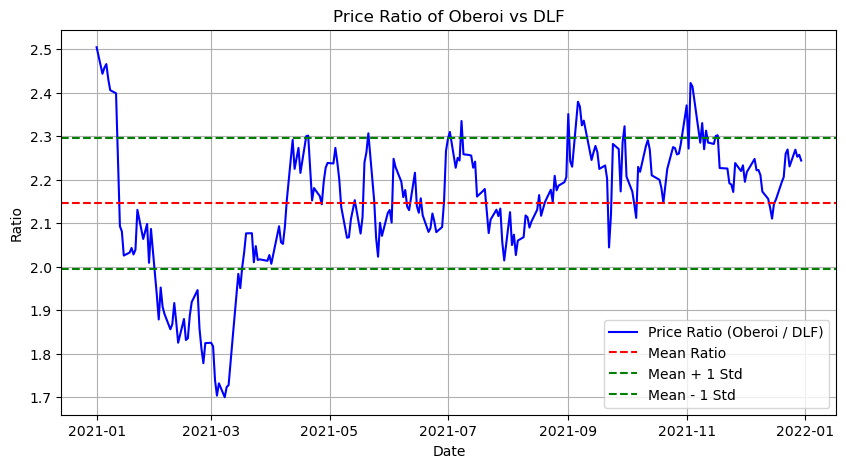

In [56]:
# Compute Ratio (Independent / Dependent)
ratio = real_pivot["OBEROIRLTY.NS"] / real_pivot["DLF.NS"]

# Plot the Ratio
plt.figure(figsize=(10, 5))
plt.plot(ratio, label="Price Ratio (Oberoi / DLF)", color="blue")
plt.axhline(ratio.mean(), color="red", linestyle="--", label="Mean Ratio")
plt.axhline(ratio.mean() + ratio.std(), color="green", linestyle="--", label="Mean + 1 Std")
plt.axhline(ratio.mean() - ratio.std(), color="green", linestyle="--", label="Mean - 1 Std")

# Labels and Title
plt.xlabel("Date")
plt.ylabel("Ratio")
plt.title("Price Ratio of Oberoi vs DLF")
plt.legend()
plt.grid()

# Show Plot
plt.show()


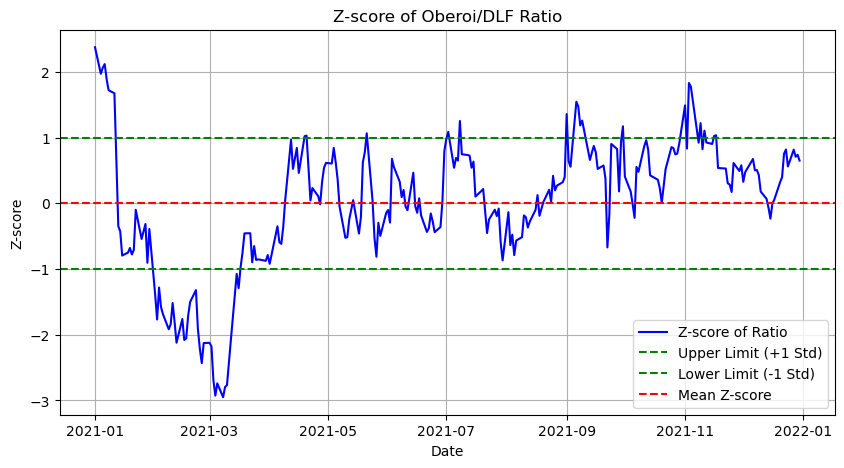

In [57]:
# Compute Ratio
ratio = real_pivot["OBEROIRLTY.NS"] / real_pivot["DLF.NS"]

# Compute Mean & Std Dev
mean_ratio = ratio.mean()
std_ratio = ratio.std()

# Compute Z-score
z_score = (ratio - mean_ratio) / std_ratio

# Plot Z-score
plt.figure(figsize=(10, 5))
plt.plot(z_score, label="Z-score of Ratio", color="blue")
plt.axhline(1, color="green", linestyle="--", label="Upper Limit (+1 Std)")
plt.axhline(-1, color="green", linestyle="--", label="Lower Limit (-1 Std)")
plt.axhline(0, color="red", linestyle="--", label="Mean Z-score")

# Labels and Title
plt.xlabel("Date")
plt.ylabel("Z-score")
plt.title("Z-score of Oberoi/DLF Ratio")
plt.legend()
plt.grid()

# Show Plot
plt.show()


In [58]:
# Create signals DataFrame
signals = pd.DataFrame({
    "Date": real_pivot.index,  # Date column
    "Asset1": real_pivot["OBEROIRLTY.NS"],  # Prestige Close Prices
    "Asset2": real_pivot["DLF.NS"],  # Brigade Close Prices
    "Z-score": z_score,  # Standardized Ratio
    "Upper Limit": 0.5,  # Upper limit (fixed at 1)
    "Lower Limit": -0.5  # Lower limit (fixed at -1)
})

# Set Date as index for better visualization
signals.set_index("Date", inplace=True)

# Display DataFrame
signals.head()


,Asset1,Asset2,Z-score,Upper Limit,Lower Limit
Date,,,,,
2021-01-01,580.527527,231.793823,2.376518,0.5,-0.5
2021-01-04,580.527527,237.580154,1.972503,0.5,-0.5
2021-01-05,577.723816,235.100296,2.064229,0.5,-0.5
2021-01-06,578.018982,234.419540,2.119835,0.5,-0.5
2021-01-07,580.134094,238.649887,1.889039,0.5,-0.5


In [59]:
# Adjust thresholds to check
signals["signals1"] = 0  # Default: No trade
signals["signals2"] = 0  # Default: No trade

signals.loc[signals["Z-score"] < -0.5, "signals1"] = 1
signals.loc[signals["Z-score"] < -0.5, "signals2"] = -1

signals.loc[signals["Z-score"] > 0.5, "signals1"] = -1
signals.loc[signals["Z-score"] > 0.5, "signals2"] = 1

print(signals.head())


                Asset1      Asset2   Z-score  Upper Limit  Lower Limit  \
Date                                                                     
2021-01-01  580.527527  231.793823  2.376518          0.5         -0.5   
2021-01-04  580.527527  237.580154  1.972503          0.5         -0.5   
2021-01-05  577.723816  235.100296  2.064229          0.5         -0.5   
2021-01-06  578.018982  234.419540  2.119835          0.5         -0.5   
2021-01-07  580.134094  238.649887  1.889039          0.5         -0.5   

            signals1  signals2  
Date                            
2021-01-01        -1         1  
2021-01-04        -1         1  
2021-01-05        -1         1  
2021-01-06        -1         1  
2021-01-07        -1         1  


In [60]:
# Compute first-order difference to track position changes
signals["positions1"] = signals["signals1"].diff().fillna(0)
signals["positions2"] = signals["signals2"].diff().fillna(0)

# Convert to integer type (to remove decimals)
signals["positions1"] = signals["positions1"].astype(int)
signals["positions2"] = signals["positions2"].astype(int)

# Display sample results
print(signals[["signals1", "positions1", "signals2", "positions2"]].head(20))


            signals1  positions1  signals2  positions2
Date                                                  
2021-01-01        -1           0         1           0
2021-01-04        -1           0         1           0
2021-01-05        -1           0         1           0
2021-01-06        -1           0         1           0
2021-01-07        -1           0         1           0
2021-01-08        -1           0         1           0
2021-01-11        -1           0         1           0
2021-01-12        -1           0         1           0
2021-01-13         0           1         0          -1
2021-01-14         0           0         0           0
2021-01-15         1           1        -1          -1
2021-01-18         1           0        -1           0
2021-01-19         1           0        -1           0
2021-01-20         1           0        -1           0
2021-01-21         1           0        -1           0
2021-01-22         0          -1         0           1
2021-01-25

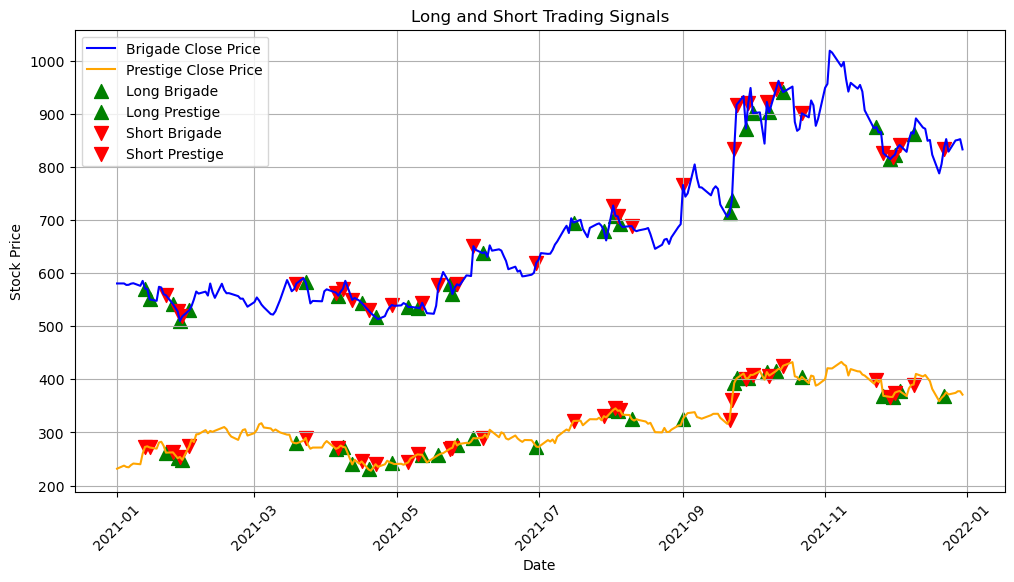

In [61]:
import matplotlib.pyplot as plt

# Plot closing prices
plt.figure(figsize=(12,6))
plt.plot(signals.index, signals["Asset1"], label="Brigade Close Price", color="blue")
plt.plot(signals.index, signals["Asset2"], label="Prestige Close Price", color="orange")

# Plot Long (Buy) Signals
plt.scatter(signals.index[signals["positions1"] == 1], 
            signals["Asset1"][signals["positions1"] == 1], 
            label="Long Brigade", marker="^", color="green", alpha=1, s=100)

plt.scatter(signals.index[signals["positions2"] == 1], 
            signals["Asset2"][signals["positions2"] == 1], 
            label="Long Prestige", marker="^", color="green", alpha=1, s=100)

# Plot Short (Sell) Signals
plt.scatter(signals.index[signals["positions1"] == -1], 
            signals["Asset1"][signals["positions1"] == -1], 
            label="Short Brigade", marker="v", color="red", alpha=1, s=100)

plt.scatter(signals.index[signals["positions2"] == -1], 
            signals["Asset2"][signals["positions2"] == -1], 
            label="Short Prestige", marker="v", color="red", alpha=1, s=100)

# Formatting the chart
plt.title("Long and Short Trading Signals")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [62]:
# Initial investment per stock
initial_capital = 200000
total_initial_investment = initial_capital * 2  # Since we invest in two stocks

# Calculate the number of shares held based on positions
signals["holdings1"] = signals["positions1"].cumsum() * signals["Asset1"]
signals["holdings2"] = signals["positions2"].cumsum() * signals["Asset2"]

# Compute cash balance
signals["cash1"] = initial_capital - (signals["positions1"] * signals["Asset1"]).cumsum()
signals["cash2"] = initial_capital - (signals["positions2"] * signals["Asset2"]).cumsum()

# Compute the total portfolio value
signals["total_portfolio_value"] = signals["holdings1"] + signals["holdings2"] + signals["cash1"] + signals["cash2"]

# Portfolio return = (Final Value - Initial Investment) / Initial Investment
final_portfolio_value = signals["total_portfolio_value"].iloc[-1]
portfolio_return = (final_portfolio_value - total_initial_investment) / total_initial_investment

# Print final portfolio value and return percentage
print(f"Final Portfolio Value: {final_portfolio_value:.2f}")
print(f"Portfolio Return: {portfolio_return * 100:.2f}%")


Final Portfolio Value: 400599.21
Portfolio Return: 0.15%


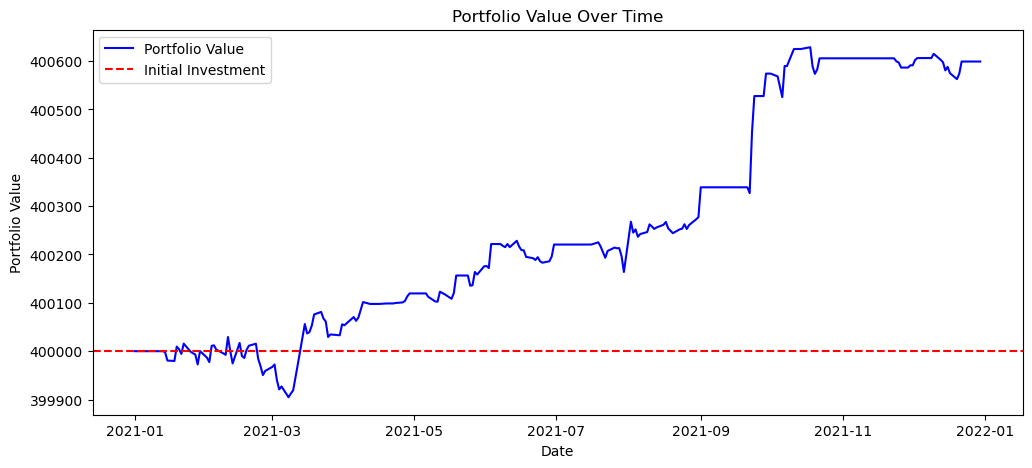

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(signals.index, signals["total_portfolio_value"], label="Portfolio Value", color="blue")
plt.axhline(y=total_initial_investment, color="red", linestyle="--", label="Initial Investment")
plt.legend()
plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.show()
